## Lock module basics
In this notebook, we set up a basic simulation where two vessels move over a 1D network path that contains a shipping lock. 

We take the following steps:

1. [Imports](#1.-Imports)
    * [Initialise environment](#Initialise-environment)
2. [Create vessel](#2.-Create-vessel)
3. [Create graph](#3.-Create-graph)
    * [Add hydrodynamic data](#3.1.-Add-hydrodynamic-data)
    * [Add lock](#3.2.-Add-lock)
4. [Run simulation](#4.-Run-simulation)
5. [Inspect output](#5.-Inspect-output)

### 1. Imports
We start with importing required libraries

In [1]:
import networkx as nx
from shapely.geometry import Point,LineString,Polygon

import datetime
import simpy

from opentnsim import core as core_module
from opentnsim import graph as graph_module
from opentnsim import lock as lock_module
from opentnsim import output as output_module
from opentnsim import vessel as vessel_module
from opentnsim import vessel_traffic_service as vessel_traffic_service_module

import pandas as pd

import matplotlib.pyplot as plt

#### Initialise environment
For later convenience we already initialise a simpy environment, with some additional properties related to the simulation start and stop time.

In [2]:
t_start = datetime.datetime(2024, 1, 1, 0, 0, 0)

env = simpy.Environment(initial_time=t_start.timestamp())

env.epoch = t_start
env.simulation_start = t_start

### 2. Create vessel
We start with creating a vessel class. We call this class a *Vessel*, and add a number of OpenTNSim mix-ins to this class. Each mix-in requires certain input parameters. We wrap the creation of the vessel class in a function, to facilitate the generation of multiple vessels. 

The following mix-ins are sufficient to create a vessel for our problem: 
* _Identifiable_ - allows to give the vessel a name and a random ID, 
* _SimpyObject_ -
* _HasLock_ - the lock chamber where vessels stay during the leveling process
* _HasLineUpArea_ - a place just in front of the lock to guide vessels entering the lock chamber
* _HasWaitingArea_ - a place where vessels can wait before entering the lock
* _VesselProperties_ - allows the specification of vessel properties, such as L, B and T
* _ExtraMetadata_ -
* _HasOutput_ -

In [3]:
#We create a type element that schematisizes a vessel
def create_vessel(env, 
                  name, 
                  origin, 
                  destination, 
                  vessel_type, 
                  L, 
                  B, 
                  T,
                  v,
                  arrival_time):
    Vessel = type('Vessel',(lock_module.HasLockComplex,
                            vessel_module.IsVessel,
                           ),{})    

    vessel = Vessel(
        **{ "env": env,
            "name": name,
            "origin": origin,
            "destination": destination,
            "type": vessel_type,
            "L": L,
            "B": B,
            "T": T,
            "v": v,
            "arrival_time": arrival_time
        }
    )

    env.process(vessel.move())
    
    return vessel

### 3. Create graph
Next we create a 1D network (a graph) along which the vessel can move. A graph is made of nodes (blue dots in the plot below) and edges (red arrows between the nodes in the plot below). We use the graph_module of OpenTNSim to do this. 

In [4]:
# specifiy nodes and edges
node_A = graph_module.Node(name='A',geometry=Point(153500,463000))
node_B = graph_module.Node(name='B',geometry=Point(155500,463000))

edges = [(node_A,node_B)]

# create a graph object
FG = graph_module.DiGraph(edges=edges,crs='EPSG:28992').graph
env.FG = nx.MultiDiGraph(FG)

# add a VTS to the environment to know where vessels are going
env.vessel_traffic_service = vessel_traffic_service_module.VesselTrafficService(FG=FG)

In [5]:
# collect node positions and labels
nodes = []
coordinates = []
labels = {}

for node in env.FG.nodes:
    nodes.append(node)
    coordinates.append([nx.get_node_attributes(env.FG, 'geometry')[node].x, nx.get_node_attributes(env.FG, 'geometry')[node].y])
    labels[node] = node
    
positions = dict(zip(nodes, coordinates))

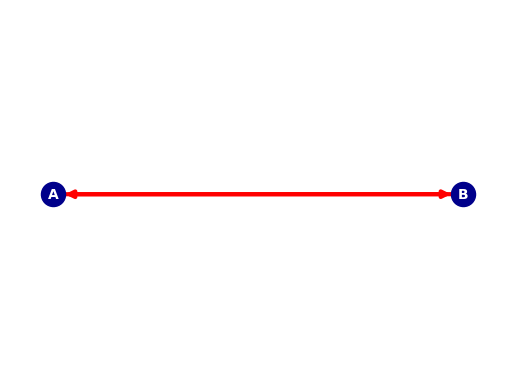

In [6]:
# draw edges, nodes and labels
nx.draw_networkx_edges(env.FG, pos=positions, width=3, edge_color="red", alpha=1, arrowsize=10)
nx.draw_networkx_nodes(env.FG, pos=positions, node_color="darkblue", node_size=300)
nx.draw_networkx_labels(env.FG, pos=positions, labels=labels, font_size=10, font_weight="bold", font_color="white")

plt.axis("off")
plt.show()

In [7]:
# we add a lock to an edge in the network
lock_I = lock_module.IsLockComplex(env=env,
                                   name='Lock I',
                                   start_node='A',
                                   node_open='A',
                                   end_node='B',
                                   lock_length = 500,
                                   lock_width = 40,
                                   lock_depth = 10.5,
                                   lineup_area_A_length=500,
                                   lineup_area_B_length=500,
                                   levelling_time=1500,
                                   doors_open=600,
                                   doors_close=600,
                                   distance_doors_A_from_waiting_area_A=750,
                                   distance_doors_B_from_waiting_area_B=750,
                                   distance_waiting_area_A_from_start_node=0,
                                   distance_waiting_area_B_from_end_node=0,
                                   distance_lineup_area_A_to_lock_doors_A=100,
                                   distance_lineup_area_B_to_lock_doors_B=100)

### 4. Run simulation

#### 4.1 Create a tracking diagram
We show how to create a tracking diagram of two vessels passing a lock.

We use the _create_vessel_ method to generate two vessels and run the simulation

In [8]:
vessel_1 = create_vessel(env=env, 
                         name='Vessel_1', 
                         origin='A', 
                         destination='B', 
                         vessel_type='inland vessel', 
                         L=200, 
                         B=30, 
                         T=10,
                         v=4,
                         arrival_time=datetime.datetime(2024, 1, 1, 1, 0, 0))

vessel_2 = create_vessel(env=env, 
                         name='Vessel_2', 
                         origin='B', 
                         destination='A', 
                         vessel_type='inland vessel', 
                         L=200, 
                         B=30, 
                         T=10,
                         v=4,
                         arrival_time=datetime.datetime(2024, 1, 1, 0, 0, 0))

vessels = [vessel_1, vessel_2]

env.run()

0.0 provide geometry
0.002989530563354492 provide location
0.0 provide geometry
0.0016016960144042969 provide location
0.0 provide geometry
0.0019979476928710938 provide location
0.0 provide geometry
0.0009925365447998047 provide location
0.0 provide geometry
0.00034356117248535156 provide location
0.0 provide geometry
0.0 provide geometry
0.0001418590545654297 provide location
0.0 provide geometry
0.0009961128234863281 provide location
0.0 provide geometry
0.0 provide location
0.0 provide geometry
0.0 provide location
0.0 provide geometry
0.0012369155883789062 provide location
0.0 provide geometry
0.0 provide location
0.0010411739349365234 provide geometry
0.0010411739349365234 provide location
0.0 provide geometry
0.0 provide location
0.0 provide geometry
0.0 provide location
0.0 provide geometry
0.0 provide geometry
0.0 provide location
0.0 provide geometry
0.0 provide location
0.0 provide geometry
0.0 provide location
0.0 provide geometry
0.0 provide location
0.0 provide geometry
0

In [9]:
vessel_1_df = pd.DataFrame(vessel_1.logbook)
vessel_2_df = pd.DataFrame(vessel_2.logbook)

In [10]:
import numpy as np
import matplotlib.dates as mdates

0.0 provide geometry
0.006981372833251953 provide distance to location
0.0 provide geometry
0.0 provide distance to location
0.0 provide geometry
0.0014789104461669922 provide distance to location
0.0 provide geometry
0.0 provide distance to location
0.0 provide geometry
0.0 provide distance to location
0.0 provide geometry
0.0 provide distance to location
0.0 provide geometry
0.0 provide distance to location
0.0 provide geometry
0.0 provide distance to location
0.0 provide geometry
0.0 provide distance to location
0.0 provide geometry
0.0 provide distance to location
0.0 provide geometry
0.0 provide distance to location
0.0 provide geometry
0.0 provide distance to location
0.0 provide geometry
0.0 provide distance to location
0.0 provide geometry
0.0 provide distance to location
0.0 provide geometry
0.0 provide distance to location
0.0 provide geometry
0.0 provide distance to location
0.0 provide geometry
0.0 provide distance to location
0.0 provide geometry
0.0 provide distance to lo

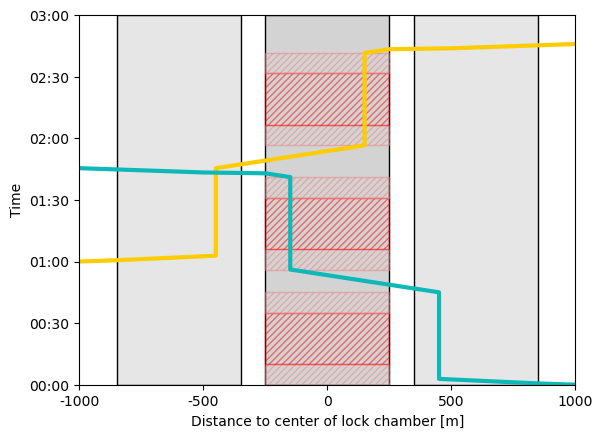

In [11]:
fig, axes = plt.subplots(1,1)
# create time distance diagram
ylim = (pd.Timestamp('2024-01-01'),pd.Timestamp('2024-01-01 03:00'))
color_vessel2 = [12/255,184/255,184/255]
color_vessel1 = [255/255,204/255,0/255]
lock_I.create_time_distance_diagram(vessels,ax=axes,accuracy=1000,ylim=ylim,vessel_colors=[color_vessel1, color_vessel2])
axes.set_xlim(0,2000)
axes.set_xticklabels(np.arange(-1000,2500,500));
xlim_min,xlim_max= [750,1250]
ylim_min,ylim_max= axes.get_ylim()

axes.fill([150,150,650,650],[ylim_min,ylim_max,ylim_max,ylim_min],color=[0.9,0.9,0.9],edgecolor='k')
axes.fill([1350,1350,1850,1850],[ylim_min,ylim_max,ylim_max,ylim_min],color=[0.9,0.9,0.9],edgecolor='k')
axes.yaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
axes.set_ylabel('Time')


lock_df = pd.DataFrame(lock_I.logbook)
for loc,info in lock_df.iterrows():
    if info.Message == 'Lock chamber converting stop':
        door_opening_time = lock_df.loc[loc].Timestamp
        door_closing_time = lock_df.loc[loc-1].Timestamp
        axes.fill([xlim_min,xlim_min,xlim_max,xlim_max],
                [door_opening_time,door_closing_time,door_closing_time,door_opening_time],
                hatch='/////',color='none',edgecolor='red',alpha=0.5,zorder=1)
    if info.Message == 'Lock doors closing stop':
        door_opening_time = lock_df.loc[loc].Timestamp
        door_closing_time = lock_df.loc[loc-1].Timestamp
        axes.fill([xlim_min,xlim_min,xlim_max,xlim_max],
                [door_opening_time,door_closing_time,door_closing_time,door_opening_time],
                hatch='/////',color='none',edgecolor='lightcoral',alpha=0.5,zorder=1)
    if info.Message == 'Lock doors opening stop':
        door_opening_time = lock_df.loc[loc].Timestamp
        door_closing_time = lock_df.loc[loc-1].Timestamp
        axes.fill([xlim_min,xlim_min,xlim_max,xlim_max],
                [door_opening_time,door_closing_time,door_closing_time,door_opening_time],
                hatch='/////',color='none',edgecolor='lightcoral',alpha=0.5,zorder=1)

# # add markers of vessel 1
# axes.plot(-130,vessel_1_df[(vessel_1_df.Message=='Waiting in line-up area start')].Timestamp.item(), 'ro')
# axes.plot(-130,vessel_1_df[(vessel_1_df.Message=='Waiting in line-up area stop')].Timestamp.item(), 'ro')
# axes.plot(-60,vessel_1_df[(vessel_1_df.Message=='Sailing to first set of lock doors stop')].Timestamp.item(), 'ro')
# axes.plot(10,vessel_1_df[(vessel_1_df.Message=='Sailing to assigned location in lock stop')].Timestamp.item(), 'ro')
# axes.plot(10,vessel_1_df[(vessel_1_df.Message=='Sailing to second set of lock doors start')].Timestamp.item(), 'ro')
# axes.plot(60,vessel_1_df[(vessel_1_df.Message=='Sailing to second set of lock doors stop')].Timestamp.item(), 'ro')

# # add markers of vessel 2
# axes.plot(130,vessel_2_df[(vessel_2_df.Message=='Waiting in line-up area start')].Timestamp.item(), 'bo')
# axes.plot(130,vessel_2_df[(vessel_2_df.Message=='Waiting in line-up area stop')].Timestamp.item(), 'bo')
# axes.plot(60,vessel_2_df[(vessel_2_df.Message=='Sailing to first set of lock doors stop')].Timestamp.item(), 'bo')
# axes.plot(-10,vessel_2_df[(vessel_2_df.Message=='Sailing to assigned location in lock stop')].Timestamp.item(), 'bo')
# axes.plot(-10,vessel_2_df[(vessel_2_df.Message=='Sailing to second set of lock doors start')].Timestamp.item(), 'bo')
# axes.plot(-60,vessel_2_df[(vessel_2_df.Message=='Sailing to second set of lock doors stop')].Timestamp.item(), 'bo')

# axes.set_xlabel('')
# axes.set_xlabel('')
# axes.set_title('Lock I');

The above tracking diagram corresponds to Part III - Figure 3.5 in Van Koningsveld et al (2023), https://doi.org/10.5074/T.2021.004.

#### 4.2 Fitting multiple vessels in a lock

#### 4.3 Accounting for realistic waterlevels

#### 4.4 Estimating salt flux during locking

#### 4.5 Applying locking regimes